In [1]:
import os, sys
sys.path.append('.')

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import torch
import torch.utils.data
from torchvision import datasets, transforms

In [2]:
from torchvision.datasets import MNIST

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [107]:
x_train_orig = training_data.data
x_train_flat = torch.flatten(x_train_orig, start_dim=1).float().numpy() + 1
y_train = training_data.targets.numpy()

x_test_orig = test_data.data
x_test_flat = torch.flatten(x_test_orig, start_dim=1).float().numpy() + 1
y_test = test_data.targets.numpy()

In [4]:
x_train_flat[:5], y_train[:5], x_train_flat.shape, y_train.shape

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
 array([5, 0, 4, 1, 9]),
 (60000, 784),
 (60000,))

In [5]:
from nnlocallinear import NLS, LLS, NNPredict

parameter = {
        'es_give_up_after_nepochs': 20
        , 'hidden_size': 100
        , 'num_layers': 3
        , 'n_classification_labels': len(training_data.classes)
        , 'penalization_thetas': 0.0
    }

model = NLS(
    verbose=3
    , es=True
    , gpu=False
    , scale_data=True
    , varying_theta0=True
    , fixed_theta0=False
    , dataloader_workers=0
    , **parameter
) 
    
model.fit(x_train_flat, y_train)

Finished epoch 0 with batch size 300 and train loss 4.412544051806132
Finished epoch 0 with batch size 2000 and validation loss 0.8112457275390625
This is the lowest validation loss so far.
Finished epoch 1 with batch size 301 and train loss 2.30490505367845
Finished epoch 1 with batch size 2000 and validation loss 0.6751281082630157
This is the lowest validation loss so far.
Finished epoch 2 with batch size 305 and train loss 1.8430333198772537
Finished epoch 2 with batch size 2000 and validation loss 0.5751220047473907
This is the lowest validation loss so far.
Finished epoch 3 with batch size 312 and train loss 1.5242363331331448
Finished epoch 3 with batch size 2000 and validation loss 0.5101628869771957
This is the lowest validation loss so far.
Finished epoch 4 with batch size 322 and train loss 1.433713028974393
Finished epoch 4 with batch size 2000 and validation loss 0.4661498963832855
This is the lowest validation loss so far.
Finished epoch 5 with batch size 335 and train lo

NLS(dataloader_workers=0, es_give_up_after_nepochs=20, fixed_theta0=False,
    gpu=False, n_classification_labels=10, penalization_thetas=0.0, verbose=3)

In [9]:
pred_labels = model.predict(x_test_flat)
pred_proba = model.predict_proba(x_test_flat)
thetas = model.get_thetas(x_test_flat, net_scale=True)[2]

In [423]:
from sklearn import metrics
print(metrics.accuracy_score(test_data.targets, pred_labels))
metrics.confusion_matrix(test_data.targets, pred_labels)

0.973


array([[ 970,    0,    1,    0,    0,    1,    4,    1,    2,    1],
       [   0, 1127,    3,    1,    0,    1,    2,    0,    1,    0],
       [   4,    0, 1005,    2,    1,    1,    3,    8,    8,    0],
       [   0,    0,    6,  970,    0,   13,    0,    6,    6,    9],
       [   3,    0,    6,    1,  949,    0,    3,    2,    3,   15],
       [   3,    0,    0,   10,    1,  865,    4,    1,    7,    1],
       [   6,    2,    2,    1,    5,    4,  935,    0,    3,    0],
       [   0,    5,    9,    1,    0,    1,    0,  995,    4,   13],
       [   2,    1,    5,    5,    2,    8,    0,    4,  944,    3],
       [   1,    6,    2,    9,    9,    4,    0,    5,    3,  970]])

In [415]:
import itertools
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.sparse import issparse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from skimage import feature, transform


class ImagePlot(object):
    
    @classmethod
    def compare(cls, img, importance, contra, real_label, counter_label, probs):
        f, ax = plt.subplots(ncols=3, figsize=(12, 5))
        
        plot = cls.plot_instances(img, ax=ax[0])
        plot = cls.plot_importance(importance, real_label, probs[real_label], ax=ax[1])
        plot = cls.plot_importance(contra, counter_label, probs[counter_label], ax=ax[2])
        f.tight_layout()
        
        ax[0].set_title(f"Real digit: {real_label}", fontsize=20)
        
        return f, ax

    @staticmethod
    def color_map():
        colors = cm.get_cmap("bwr", 201)
        scale_color = [*range(0, 50, 1)] + [*range(50, 80, 8)]
        scale_color1 = [*range(120, 150, 8)] + [*range(150, 200, 1)]
        newcolors = colors(scale_color + [*range(98, 104)] + scale_color1)
        newcmp = matplotlib.colors.ListedColormap(newcolors)
        # newcmp = colors
        return newcmp

    @classmethod
    def plot_importance(cls, importance, label, prob, shape=None, standardization=False, ax=None, x_explain=None, simple=False):
        if standardization:
            importance = importance / np.std(importance)
        if shape is None:
            n_importance = importance.shape
            n_size = int(np.sqrt(n_importance))
            shape = (n_size, n_size)

        max_importance = np.max(importance)
        min_importance = np.min(importance)
        max_scale = np.max(np.abs([max_importance, max_importance]))

        importance = importance.reshape(shape)
        if ax is None:
            fig, ax = plt.subplots(figsize=(5, 5))
            fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

        cmap_ = cls.color_map()

        dx, dy = 0.05, 0.05
        xx = np.arange(0.0, importance.shape[1] + dx, dx)
        yy = np.arange(0.0, importance.shape[0] + dy, dy)
        xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
        extent = xmin, xmax, ymin, ymax

        cp_importance, cbar = cls.plot_importance_(
            importance=importance,
            title=" ",
            ax=ax,
            extent=extent,
            cmap=cmap_,
            vmax=max_scale,
            vmin=-max_scale
        )
        if simple:
            cbar.ax.set_xlabel(fr"$\delta_i$({label})", fontsize=20, labelpad=5)
        else:
            cbar.ax.set_xlabel(fr"$\delta_i$({label}); P(y = {label}) = {prob:.2f}", fontsize=25, labelpad=5)
        if x_explain is not None:
           cls.plot_mask(data=x_explain, ax=ax, extent=extent)

        return ax, cp_importance

    @staticmethod
    def plot_mask(data, ax, extent=None, dilation=3.0, alpha=0.5):
        data = data[0]
        mean = data if len(data.shape) == 2 else np.mean(data, axis=-1)
        in_image_upscaled = transform.rescale(mean, dilation, mode="constant")
        mask = feature.canny(in_image_upscaled).astype(float)
        mask[mask < 0.5] = np.nan
        # plot
        cmap = plt.get_cmap("Greys_r")
        ax.imshow(mask, extent=extent, interpolation="none", cmap=cmap, alpha=alpha)
        return ax

    @staticmethod
    def plot_importance_(importance, title, ax, extent=None, **kwarg):
        ax.set_title(title, fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
        cp = ax.imshow(importance, extent=extent, interpolation="none", **kwarg)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cbar = plt.colorbar(cp, cax=cax, orientation="horizontal", fraction=0.07, anchor=(1.0, 0.0))
        cbar.ax.tick_params(labelsize=13, pad=-1, direction="in")
        cax.xaxis.set_ticks_position("top")
        cax.xaxis.set_label_position("top")
        return cp, cbar

    @classmethod
    def plot_instances(cls, x_=None, y_=None, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(y_, fontsize=18)
        colors = matplotlib.cm.get_cmap("Greys", 200)
        scale_color = [*range(0, 100, 8)] + [*range(100, 200, 1)]
        newcolors = colors(scale_color)
        newcmp = matplotlib.colors.ListedColormap(newcolors)
        return ax.imshow(x_, interpolation="none", cmap=newcmp)

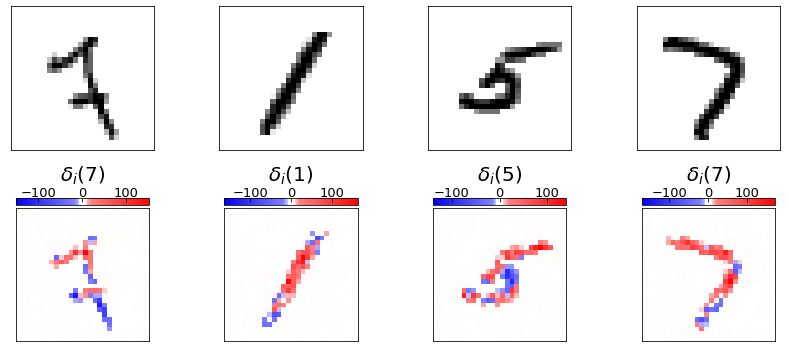

In [416]:
index = np.random.randint(low=0, high=len(y_test), size=4)
labels = y_test[index]
imgs = x_test_flat[index]
thetas_instances = thetas[index, :, labels] * imgs

f, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
for i in range(len(index)):
    ImagePlot.plot_instances(x_test_orig[index[i]], ax=ax[0, i])
    ImagePlot.plot_importance(thetas_instances[i], ax=ax[1, i], label=labels[i], prob=1, simple=True)
f.tight_layout()
f.savefig('img/digits/example_random.pdf')

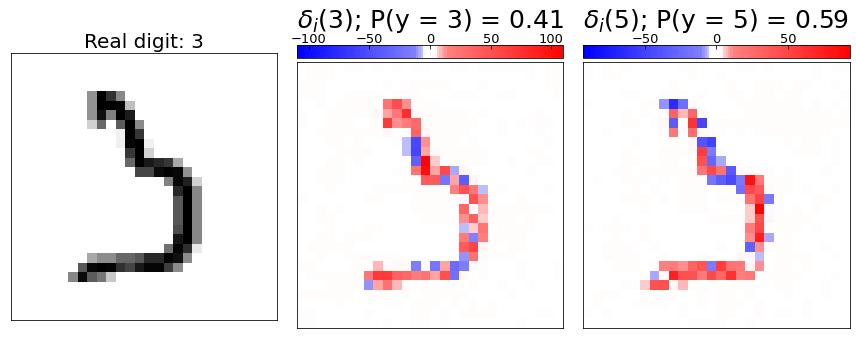

In [417]:
index = 883
label = y_test[index]
label_counter = 5

img = x_test_orig[index]
img_flat = x_test_flat[index]
thetas_instance = thetas[index][:, label].flatten() * img_flat
thetas_counter = thetas[index][:, label_counter].flatten() * img_flat

f, ax = ImagePlot.compare(img, thetas_instance, thetas_counter, real_label=y_test[index], counter_label=label_counter, probs=pred_proba[index])
f.savefig("img/digits/example1.pdf")

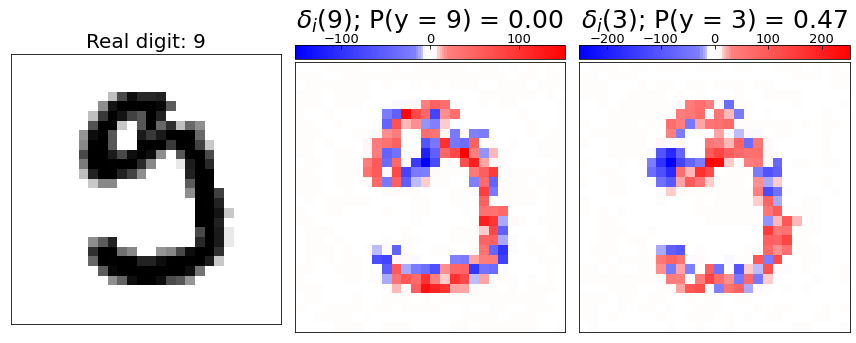

In [418]:
index = 1247
label = y_test[index]
label_counter = 3

img = x_test_orig[index]
img_flat = x_test_flat[index]
thetas_instance = thetas[index][:, label].flatten() * img_flat
thetas_counter = thetas[index][:, label_counter].flatten() * img_flat

f, ax = ImagePlot.compare(img, thetas_instance, thetas_counter, real_label=y_test[index], counter_label=label_counter, probs=pred_proba[index])
f.savefig("img/digits/example2.pdf")

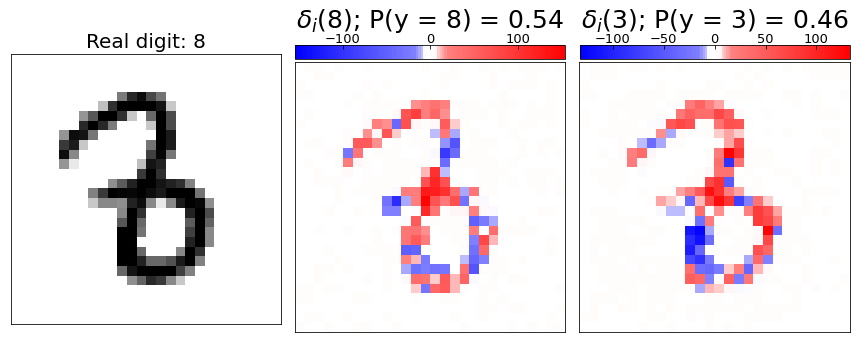

In [419]:
index = 1878
label = y_test[index]
label_counter = 3

img = x_test_orig[index]
img_flat = x_test_flat[index]
thetas_instance = thetas[index][:, label].flatten() * img_flat
thetas_counter = thetas[index][:, label_counter].flatten() * img_flat

f, ax = ImagePlot.compare(img, thetas_instance, thetas_counter, real_label=y_test[index], counter_label=label_counter, probs=pred_proba[index])
f.savefig("img/digits/example3.pdf")

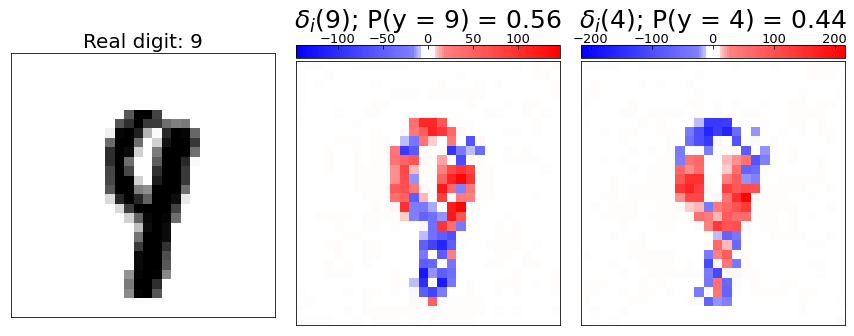

In [420]:
index = 2720
label = y_test[index]
label_counter = 4

img = x_test_orig[index]
img_flat = x_test_flat[index]
thetas_instance = thetas[index][:, label].flatten() * img_flat
thetas_counter = thetas[index][:, label_counter].flatten() * img_flat

f, ax = ImagePlot.compare(img, thetas_instance, thetas_counter, real_label=y_test[index], counter_label=label_counter, probs=pred_proba[index])
f.savefig("img/digits/example4.pdf")

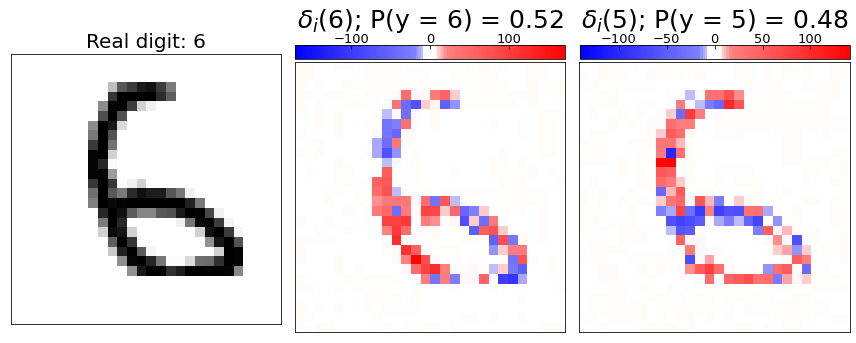

In [421]:
index = 2721
label = y_test[index]
label_counter = 5

img = x_test_orig[index]
img_flat = x_test_flat[index]
thetas_instance = thetas[index][:, label].flatten() * img_flat
thetas_counter = thetas[index][:, label_counter].flatten() * img_flat

f, ax = ImagePlot.compare(img, thetas_instance, thetas_counter, real_label=y_test[index], counter_label=label_counter, probs=pred_proba[index])
f.savefig("img/digits/example5.pdf")